In [1]:
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle
import matplotlib.pyplot as plt

from symfac.experimental import RBFExpansionV2
from symfac.experimental import RBFExpansionMiniBatch

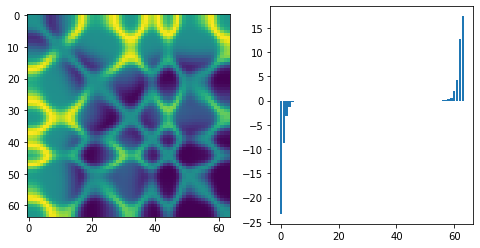

[0.13909, 0.06549, 0.0267, 0.00791, 0.0037, 0.00134, 0.00047, 0.0001, 5e-05]


In [2]:
def rbf(X, Y=None):
    return np.exp(-np.subtract.outer(X, Y if Y is not None else X)**2)

n = 64

np.random.seed(128)
u = 5 * np.random.randn(n)
v = 4 * np.random.randn(n)
u = gaussian_filter1d(u, 3., order=0)
v = gaussian_filter1d(v, 6., order=0)

K = rbf(u) - rbf(v)
Kt = torch.tensor(K, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(K)
axs[1].bar(np.arange(n), np.linalg.eigvalsh(K))
plt.show()

U, S, V = np.linalg.svd(K)
svd_K = []
for k in range(1, 10):
    truncation = (U[:, :k] * S[None, :k]) @ V[:k, :]
    svd_K.append(round(float(F.mse_loss(torch.tensor(truncation), torch.tensor(K))), 5))
print(svd_K)

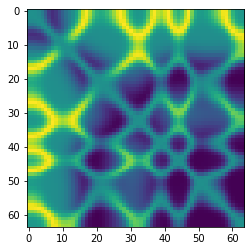

In [3]:
plt.imshow(Kt)

In [18]:
k = 4
dim = 64
batch_size=100
max_steps=10001

In [19]:
torch.manual_seed(15513512)

u_start=0.1*torch.randn([batch_size, dim, k], device="cuda") 
a=torch.randn([batch_size, k], device="cuda")
b=torch.randn([batch_size], device="cuda")


In [7]:
u_start

tensor([[[-5.5741e-02,  4.4341e-02],
         [ 5.1032e-02,  5.6333e-02],
         [-2.0743e-01,  8.8627e-02],
         ...,
         [ 2.2001e-01,  5.5230e-02],
         [ 3.5332e-02,  4.1364e-02],
         [ 2.9219e-02,  8.4191e-02]],

        [[ 5.5577e-02, -1.3550e-02],
         [-1.7161e-01,  1.0917e-01],
         [-1.0475e-01,  4.7051e-03],
         ...,
         [-1.1577e-01, -1.0594e-01],
         [-1.9542e-01, -1.7466e-01],
         [ 4.1115e-02, -2.1629e-01]],

        [[ 5.2174e-02,  4.1653e-02],
         [-1.3138e-02, -6.1304e-02],
         [ 2.3225e-01,  5.0453e-02],
         ...,
         [-3.2201e-02,  1.5620e-02],
         [ 5.3046e-02, -9.1653e-02],
         [ 8.0394e-02, -9.9725e-03]],

        ...,

        [[ 7.5053e-02, -6.1522e-02],
         [ 1.9440e-01,  2.5678e-03],
         [-3.1723e-02, -7.3891e-02],
         ...,
         [ 1.2405e-01, -7.3018e-02],
         [-4.4658e-02,  8.3877e-02],
         [-1.5364e-01,  1.3344e-01]],

        [[ 8.4380e-02,  8.8526e-03

In [20]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
fac0 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='SGD')
fac0.fith(
    Kt,
    u0=u0,
    #v0=v0,
    a0=a0,
    b0=b0
  )
fac0.to_pickle(f'data/optim-SGD.pickle')
print(torch.min(fac0.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 573.16it/s]

tensor(0.0022)


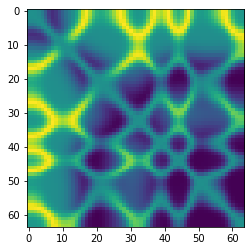

In [21]:
plt.imshow(Kt)

In [22]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
fac1 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps)
fac1.fith(
    Kt,
    u0=u0,
    #v0=v0,
    a0=a0,
    b0=b0
  )
fac1.to_pickle(f'data/optim-Adam.pickle')
print(torch.min(fac1.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 583.52it/s]

tensor(4.5616e-15)


In [23]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)

fac2 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='Adadelta')
fac2.fith(
    Kt,
    u0=u0,
    a0=a0,
    b0=b0
  )
fac2.to_pickle(f'data/optim-Adadelta.pickle')
print(torch.min(fac2.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 567.98it/s]

tensor(0.0023)


In [24]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)

fac3 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='Adagrad')
fac3.fith(
    K.astype(np.float32),
    u0=u0,
    a0=a0,
    b0=b0
  )
fac3.to_pickle(f'data/optim-Adagrad.pickle')
print(torch.min(fac3.report.loss_best))

100%|██████████| 10001/10001 [00:18<00:00, 549.59it/s]

tensor(2.9906e-06)


In [25]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)

fac4 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='RMSprop')
fac4.fith(
    K.astype(np.float32),
    u0=u0,
    a0=a0,
    b0=b0
  )
fac4.to_pickle(f'data/optim-RMSprop.pickle')
print(torch.min(fac4.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 558.70it/s]

tensor(0.0300)


In [26]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)

fac5 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='AdamW')
fac5.fith(
    K.astype(np.float32),
    u0=u0,
    a0=a0,
    b0=b0
  )
fac5.to_pickle(f'data/optim-AdamW.pickle')
print(torch.min(fac5.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 578.83it/s]

tensor(5.8242e-08)


In [27]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)

fac6 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=max_steps, algorithm='ASGD')
fac6.fith(
    K.astype(np.float32),
    u0=u0,
    a0=a0,
    b0=b0
  )
fac6.to_pickle(f'data/optim-ASGD.pickle')
print(torch.min(fac6.report.loss_best))

100%|██████████| 10001/10001 [00:17<00:00, 571.48it/s]

tensor(0.0023)


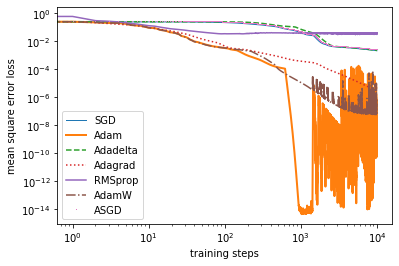

In [28]:
plt.loglog(
    fac0.report.loss_history_ticks,
    fac0.report.loss_history.min(axis=1),
    '-',
    lw = 1
)
plt.loglog(
    fac1.report.loss_history_ticks,
    fac1.report.loss_history.min(axis=1),
    '-',
    lw = 2
)
plt.loglog(
    fac2.report.loss_history_ticks,
    fac2.report.loss_history.min(axis=1),
    '--'
)

plt.loglog(
    fac3.report.loss_history_ticks,
    fac3.report.loss_history.min(axis=1),
    ':'
)
plt.loglog(
    fac4.report.loss_history_ticks,
    fac4.report.loss_history.min(axis=1)
)

plt.loglog(
    fac5.report.loss_history_ticks,
    fac5.report.loss_history.min(axis=1),
    '-.'
)

plt.loglog(
    fac6.report.loss_history_ticks,
    fac6.report.loss_history.min(axis=1),
    ','
)

plt.legend(('SGD', 'Adam', 'Adadelta', 'Adagrad', 'RMSprop', 'AdamW', 'ASGD'),
           loc='lower left')
plt.xlabel("training steps")


plt.ylabel("mean square error loss")

plt.savefig("fig-optimization.pdf", dpi=300)
plt.show()

In [29]:
batch_size

100

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
'D-DIN.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'def

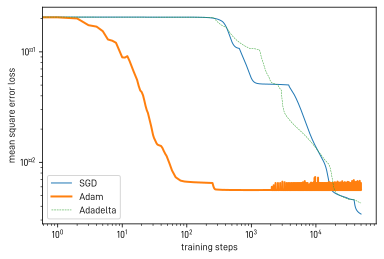

In [17]:
plt.loglog(
    fac0.report.loss_history_ticks,
    fac0.report.loss_history.min(axis=1),
    '-',
    lw = 1
)
plt.loglog(
    fac1.report.loss_history_ticks,
    fac1.report.loss_history.min(axis=1),
    '-',
    lw = 2
)
plt.loglog(
    fac2.report.loss_history_ticks,
    fac2.report.loss_history.min(axis=1),
    '--'
)


plt.legend(('SGD', 'Adam', 'Adadelta'),
           loc='lower left')
plt.xlabel("training steps")


plt.ylabel("mean square error loss")

plt.savefig("fig-optimization.pdf", dpi=300)
plt.show()

In [50]:
if True:
    open('data/paper/over-optimization-methods-SGD.pickle', 'wb').write(pickle.dumps([fac0.report.loss_history_ticks,fac0.report.loss_history.min(axis=1),'SGD']))
    open('data/paper/over-optimization-methods-Adam.pickle', 'wb').write(pickle.dumps([fac1.report.loss_history_ticks,fac1.report.loss_history.min(axis=1),'Adam']))
    open('data/paper/over-optimization-methods-Adadelta.pickle', 'wb').write(pickle.dumps([fac2.report.loss_history_ticks,fac2.report.loss_history.min(axis=1),'Adadelta']))
    open('data/paper/over-optimization-methods-Adagrad.pickle', 'wb').write(pickle.dumps([fac3.report.loss_history_ticks,fac3.report.loss_history.min(axis=1),'Adagrad']))
    open('data/paper/over-optimization-methods-RMSprop.pickle', 'wb').write(pickle.dumps([fac4.report.loss_history_ticks,fac4.report.loss_history.min(axis=1),'RMSprop']))
    open('data/paper/over-optimization-methods-AdamW.pickle', 'wb').write(pickle.dumps([fac5.report.loss_history_ticks,fac5.report.loss_history.min(axis=1),'AdamW']))
    open('data/paper/over-optimization-methods-ASGD.pickle', 'wb').write(pickle.dumps([fac6.report.loss_history_ticks,fac6.report.loss_history.min(axis=1),'ASGD']))

In [17]:
if True:
    open('data/paper/optimization-methods-SGD.pickle', 'wb').write(pickle.dumps([fac0.report.loss_history_ticks,fac0.report.loss_history.min(axis=1),'SGD']))
    open('data/paper/optimization-methods-Adam.pickle', 'wb').write(pickle.dumps([fac1.report.loss_history_ticks,fac1.report.loss_history.min(axis=1),'Adam']))
    open('data/paper/optimization-methods-Adadelta.pickle', 'wb').write(pickle.dumps([fac2.report.loss_history_ticks,fac2.report.loss_history.min(axis=1),'Adadelta']))
    open('data/paper/optimization-methods-Adagrad.pickle', 'wb').write(pickle.dumps([fac3.report.loss_history_ticks,fac3.report.loss_history.min(axis=1),'Adagrad']))
    open('data/paper/optimization-methods-RMSprop.pickle', 'wb').write(pickle.dumps([fac4.report.loss_history_ticks,fac4.report.loss_history.min(axis=1),'RMSprop']))
    open('data/paper/optimization-methods-AdamW.pickle', 'wb').write(pickle.dumps([fac5.report.loss_history_ticks,fac5.report.loss_history.min(axis=1),'AdamW']))
    open('data/paper/optimization-methods-ASGD.pickle', 'wb').write(pickle.dumps([fac6.report.loss_history_ticks,fac6.report.loss_history.min(axis=1),'ASGD']))

# Stochastic counterparts

In [20]:
k = 4
dim = 64
batch_size = 200
max_steps = 50000

In [21]:
u_start=1/100*torch.randn([batch_size, dim, k], device="cuda") 
a=torch.randn([batch_size, k], device="cuda")
b=torch.randn([batch_size], device="cuda")


In [22]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_0 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='SGD', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_0.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_0.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

  0%|          | 0/50000 [00:00<?, ?it/s]


tensor([[[-0.0145,  0.0134, -0.0037,  0.0119],
         [-0.0050, -0.0108, -0.0032,  0.0011],
         [-0.0004,  0.0123,  0.0086, -0.0045],
         ...,
         [ 0.0099,  0.0279,  0.0134, -0.0099],
         [-0.0157,  0.0160,  0.0250, -0.0139],
         [ 0.0049, -0.0204,  0.0110,  0.0153]],

        [[ 0.0021, -0.0193, -0.0021,  0.0191],
         [-0.0072, -0.0074, -0.0004,  0.0026],
         [-0.0026,  0.0003,  0.0004,  0.0174],
         ...,
         [ 0.0014,  0.0006,  0.0088, -0.0213],
         [ 0.0052, -0.0045,  0.0056,  0.0006],
         [ 0.0035,  0.0003,  0.0108,  0.0077]],

        [[-0.0083, -0.0160, -0.0010, -0.0019],
         [-0.0058,  0.0133, -0.0059,  0.0079],
         [-0.0092, -0.0096,  0.0036,  0.0171],
         ...,
         [ 0.0116,  0.0181,  0.0059, -0.0103],
         [ 0.0078, -0.0057, -0.0012, -0.0177],
         [ 0.0125, -0.0211, -0.0135, -0.0065]],

        ...,

        [[ 0.0198, -0.0165,  0.0073, -0.0017],
         [-0.0123, -0.0029, -0.0104, -0.0038]

NameError: name 'fac_mini_1' is not defined

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_1 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='Adam', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_1.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_2 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='Adadelta', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_2.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_2.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_3 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='Adagrad', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_3.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_3.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_4 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='RMSprop', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_4.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_4.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_5 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_5.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_5.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
u0 = torch.clone(u_start)
a0 = torch.clone(a)
b0 = torch.clone(b)
print(u0[:10])
fac_mini_6 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='ASGD', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_6.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_6.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=u0,
        a=a0,
        b=b0
)

In [ ]:
plt.loglog(
    fac_mini_0.report.loss_history_ticks,
    fac_mini_0.report.loss_history.min(axis=1),
    '-',
    lw = 1
)
plt.loglog(
    fac_mini_1.report.loss_history_ticks,
    fac_mini_1.report.loss_history.min(axis=1),
    '-',
    lw = 2
)
plt.loglog(
    fac_mini_2.report.loss_history_ticks,
    fac_mini_2.report.loss_history.min(axis=1),
    '--'
)

plt.loglog(
    fac_mini_3.report.loss_history_ticks,
    fac_mini_3.report.loss_history.min(axis=1),
    ':'
)
plt.loglog(
    fac_mini_4.report.loss_history_ticks,
    fac_mini_4.report.loss_history.min(axis=1)
)

plt.loglog(
    fac_mini_5.report.loss_history_ticks,
    fac_mini_5.report.loss_history.min(axis=1),
    '-.'
)

plt.loglog(
    fac_mini_6.report.loss_history_ticks,
    fac_mini_6.report.loss_history.min(axis=1),
    ','
)

plt.legend(('SGD', 'Adam', 'Adadelta', 'Adagrad', 'RMSprop', 'AdamW', 'ASGD'),
           loc='lower left')
plt.xlabel("training steps")


plt.ylabel("mean square error loss")

plt.savefig("fig-optimization.pdf", dpi=300)
plt.show()

In [ ]:
print(torch.min(fac_mini_1.report.loss_best))

In [ ]:
if False:
    open('data/stoc4-optimization-methods-SGD.pickle', 'wb').write(pickle.dumps([fac_mini_0.report.loss_history_ticks,fac_mini_0.report.loss_history.min(axis=1),'SGD']))
    open('data/stoc4-optimization-methods-Adam.pickle', 'wb').write(pickle.dumps([fac_mini_1.report.loss_history_ticks,fac_mini_1.report.loss_history.min(axis=1),'Adam']))
    open('data/stoc4-optimization-methods-Adadelta.pickle', 'wb').write(pickle.dumps([fac_mini_2.report.loss_history_ticks,fac_mini_2.report.loss_history.min(axis=1),'Adadelta']))
    open('data/stoc4-optimization-methods-Adagrad.pickle', 'wb').write(pickle.dumps([fac_mini_3.report.loss_history_ticks,fac_mini_3.report.loss_history.min(axis=1),'Adagrad']))
    open('data/stoc4-optimization-methods-RMSprop.pickle', 'wb').write(pickle.dumps([fac_mini_4.report.loss_history_ticks,fac_mini_4.report.loss_history.min(axis=1),'RMSprop']))
    open('data/stoc4-optimization-methods-AdamW.pickle', 'wb').write(pickle.dumps([fac_mini_5.report.loss_history_ticks,fac_mini_5.report.loss_history.min(axis=1),'AdamW']))
    open('data/stoc4-optimization-methods-ASGD.pickle', 'wb').write(pickle.dumps([fac_mini_6.report.loss_history_ticks,fac_mini_6.report.loss_history.min(axis=1),'ASGD']))

# Histograms

In [36]:
batch_size = 100
bs=batch_size

100%|██████████| 10001/10001 [00:24<00:00, 400.50it/s]


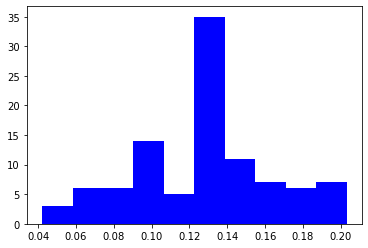

[]


In [37]:
errors = []
bs=100
for k in [2]:
    u0=torch.randn([batch_size, len(K), k]) 
    a=torch.randn([batch_size, k], device="cuda")
    b=torch.randn([batch_size], device="cuda")
    fac_2_1 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=10001)
    fac_2_1.fith(
        Kt,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac_2_1.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

In [ ]:
errors = []
for k in [2]:
    u0=1/1000*torch.randn([batch_size, len(K), k]) 
    a=torch.randn([batch_size, k], device="cuda")
    b=torch.randn([batch_size], device="cuda")
    fac_2_1000 = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=30000)
    fac_2_1000.fith(
        Kt,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac_2_1000.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

100%|██████████| 10001/10001 [00:24<00:00, 409.50it/s]


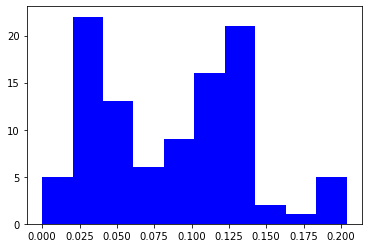

[]


In [42]:
errors = []
for k in [2]:
    u0=1/10*torch.randn([bs, len(K), k]) 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_2_10 = RBFExpansionV2(k=k, batch_size=bs, max_steps=10001)
    fac_2_10.fith(
        Kt,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac_2_10.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

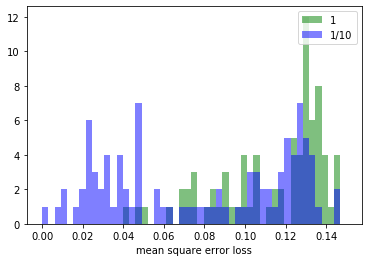

In [43]:
HIST_BINS = np.linspace(0, 0.15, 50)
plt.hist(fac_2_1.report.loss_best, HIST_BINS, alpha = 0.5, color='g', label='1')
plt.hist(fac_2_10.report.loss_best, HIST_BINS, alpha = 0.5, color='b', label='1/10')
#plt.hist(fac_2_1000.report.loss_best,HIST_BINS, alpha = 0.5, color='r', label='1/1000')
plt.legend(loc="upper right")
plt.xlabel("mean square error loss")
plt.savefig("fig-optimization-2.pdf", dpi=300)
plt.show()

In [44]:
if True:
    open('data/paper/hist_starts_2.pickle', 'wb').write(pickle.dumps([fac_2_1.report.loss_best,fac_2_10.report.loss_best]))

100%|██████████| 10001/10001 [00:20<00:00, 484.13it/s]


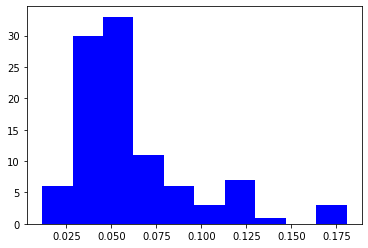

[]


In [45]:
errors = []
for k in [4]:
    u0=torch.randn([bs, len(K), k]) 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_4_1 = RBFExpansionV2(k=k, batch_size=bs, max_steps=10001)
    fac_4_1.fith(
        Kt,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac_4_1.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

100%|██████████| 10001/10001 [00:21<00:00, 469.58it/s]


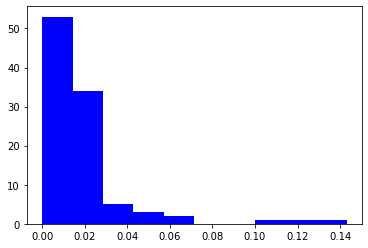

[]


In [46]:
errors = []
for k in [4]:
    u0=1/10*torch.randn([bs, len(K), k]) 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_4_10 = RBFExpansionV2(k=k, batch_size=bs, max_steps=10001)
    fac_4_10.fith(
        Kt,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.hist(fac_4_10.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

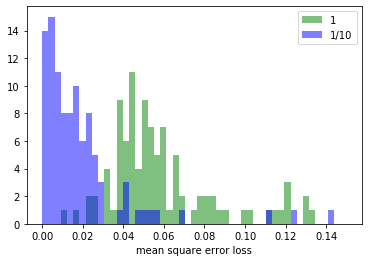

In [47]:
HIST_BINS = np.linspace(0, 0.15, 50)
plt.hist(fac_4_1.report.loss_best, HIST_BINS, alpha = 0.5, color='g', label='1')
plt.hist(fac_4_10.report.loss_best, HIST_BINS, alpha = 0.5, color='b', label='1/10')
#plt.hist(fac_2_1000.report.loss_best,HIST_BINS, alpha = 0.5, color='r', label='1/1000')
plt.legend(loc="upper right")
plt.xlabel("mean square error loss")
plt.savefig("fig-optimization-2.pdf", dpi=300)
plt.show()

In [48]:
if True:
    open('data/paper/hist_starts_4.pickle', 'wb').write(pickle.dumps([fac_4_1.report.loss_best,fac_4_10.report.loss_best]))

## Stochastic histograms

In [ ]:
k = 2
dim = 64
batch_size = 100
max_steps = 10001

In [ ]:
errors = []
bs=100
for k in [2]:
    fac_mini_01 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
    fac_mini_01.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_01.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=torch.randn([batch_size, dim, k], device="cuda") ,
        a=torch.randn([batch_size, k], device="cuda"),
        b=torch.randn([batch_size], device="cuda")

)
    plt.hist(fac_mini_01.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

In [ ]:
errors = []
fac_mini_010 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_010.fit_custom(
    Kt,
    f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_010.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=1/10*torch.randn([batch_size, dim, k], device="cuda") ,
        a=torch.randn([batch_size, k], device="cuda"),
        b=torch.randn([batch_size], device="cuda")

)
plt.hist(fac_mini_010.report.loss_best, color='b', label='1')
plt.show()

print(errors)

In [ ]:
errors = []
bs=100
for k in [2]:
    fac_mini_01000 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
    fac_mini_01000.fit_custom(
        Kt,
        f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_01000.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=1/1000*torch.randn([batch_size, dim, k], device="cuda") ,
        a=torch.randn([batch_size, k], device="cuda"),
        b=torch.randn([batch_size], device="cuda")

)
    plt.hist(fac_mini_01000.report.loss_best, color='b', label='1')
    plt.show()

print(errors)

In [ ]:
HIST_BINS = np.linspace(0, 0.15, 50)
plt.hist(fac_mini_01.report.loss_best, HIST_BINS, alpha = 0.5, color='g', label='1')
plt.hist(fac_mini_010.report.loss_best, HIST_BINS, alpha = 0.5, color='b', label='1/10')
#plt.hist(fac_mini_01000.report.loss_best,HIST_BINS, alpha = 0.5, color='r', label='1/1000')
plt.legend(loc="upper right")
plt.xlabel("mean square error loss")
plt.savefig("fig-optimization-2.pdf", dpi=300)
plt.show()

In [ ]:
open('data/hist_starts_stoc_2.pickle', 'wb').write(pickle.dumps([fac_mini_01.report.loss_best,fac_mini_010.report.loss_best]))


In [ ]:
k = 4
dim = 64
batch_size = 100
max_steps = 50000

In [ ]:
errors = []
fac_mini_4_01 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_4_01.fit_custom(
    Kt,
    f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_4_01.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=torch.randn([batch_size, dim, k], device="cuda") ,
        a=torch.randn([batch_size, k], device="cuda"),
        b=torch.randn([batch_size], device="cuda")

)
plt.hist(fac_mini_4_01.report.loss_best, color='b', label='1')
plt.show()

print(errors)

In [ ]:
errors = []
fac_mini_4_010 = RBFExpansionMiniBatch(k=k, mini_batch_size= 4 * Kt.shape[0], algorithm='AdamW', batch_size=batch_size, max_steps=max_steps, mini_batch_by='elements')
fac_mini_4_010.fit_custom(
    Kt,
    f=lambda u, a, b:
            torch.sum(
                fac_mini_1.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini_4_010.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=1/10*torch.randn([batch_size, dim, k], device="cuda") ,
        a=torch.randn([batch_size, k], device="cuda"),
        b=torch.randn([batch_size], device="cuda")

)
plt.hist(fac_mini_4_010.report.loss_best, color='b', label='1')
plt.show()

print(errors)

In [ ]:
HIST_BINS = np.linspace(0, 0.15, 50)
plt.hist(fac_mini_4_01.report.loss_best, HIST_BINS, alpha = 0.5, color='g', label='1')
plt.hist(fac_mini_4_010.report.loss_best, HIST_BINS, alpha = 0.5, color='b', label='1/10')
#plt.hist(fac_mini_01000.report.loss_best,HIST_BINS, alpha = 0.5, color='r', label='1/1000')
plt.legend(loc="upper right")
plt.xlabel("mean square error loss")
plt.show()

In [ ]:
if False:
    open('data/hist_starts_stoc_4.pickle', 'wb').write(pickle.dumps([fac_mini_4_01.report.loss_best,fac_mini_4_010.report.loss_best]))

# Sandbox below

---

In [ ]:
fig = SuperFigure(plt.figure(figsize=(__WIDTH__, __HEIGHT__), dpi=300))
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.01
dx = 0.25
w = 0.23
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        width=w,
        top=0.2,
        width_to_height=1.0,
        style='modern'
    ) for i in range(4)
]

def svd_reconstruction(k):
    U, S, V = np.linalg.svd(K)
    return torch.tensor((U[:, :k] * S[None, :k]) @ V[:k, :])

image_style = dict(
    cmap='viridis'
)
axs[0].imshow(K, **image_style)
axs[1].imshow(svd_reconstruction(1), **image_style)
axs[2].imshow(svd_reconstruction(2), **image_style)
axs[3].imshow(svd_reconstruction(4), **image_style)

title_style = dict(
    fontsize=7,
    y=1.02,
    va='top'
)

axs[0].set_title(r'\textbf{Difference of 2 Components}', **title_style)
axs[1].set_title(r'\textbf{Rank-1}', **title_style)
axs[2].set_title(r'\textbf{Rank-2}', **title_style)
axs[3].set_title(r'\textbf{Rank-4}', **title_style)

for ax in axs:
    ax.patch.set_facecolor('w')
    ax.set_xticks([])
    ax.set_yticks([])

ax_group_rbf = fig.make_axes(
    left=axs[0].left, right=axs[0].right, top=0, bottom=1,
    style='blank', zorder=-10
)
ax_group_svd = fig.make_axes(
    left=axs[1].left, right=axs[3].right, top=0, bottom=1,
    style='blank', zorder=-10
)
for ax_group in [ax_group_rbf, ax_group_svd]:
    ax_group.axhline(
        0.9,
        lw=0.5,
        color='k',
    )
group_text_style = dict(
    fontsize=8,
    ha='center',
    va='bottom',
)
ax_group_rbf.text(0.5, 0.92, r'\textbf{RBF Matrix}', **group_text_style)
ax_group_svd.text(0.5, 0.92, r'\textbf{SVD Reconstruction}', **group_text_style)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [ ]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1